# Assigment 3: CAMSHIFT
## Paper
Read the paper "Bradski_etal_1998_camshift.pdf" in KVV (under "Resources/papers"). 

## Calculate histogram
* Implement a function that creates a color histogram. Pass either an image and ROI, or the image underlying the ROI. 
* For this purpose, a second (or third) parameter can be passed to specify the number of bins. 
* Load the image "images/racecar.png" and convert the image to the HSV color space. Plot the Hue channel. (**RESULT**)

# U3a - Abdullah Barhoum (5041774) und Katharina Müller (5284090)

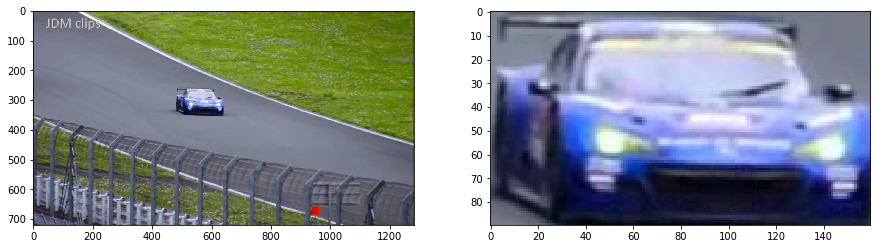

In [260]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io,color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm
import glob

IMAGES_PER_ROW = 4

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20


image = io.imread('images/racecar.png')
imageCar = image[260:350, 480:640]

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(image)
ax2.imshow(imageCar)    

In [165]:
def countInRange(arr, n, x, y): 
  
    # initialize result 
    count = 0; 
  
    for i in range(n): 
  
        # check if element is in range 
        if (arr[i] >= x and arr[i] <= y): 
            count += 1
    return count 

In [174]:
def createColorHistogramArray(img, binCount = 256):
    H, W, C = image.shape
    total_number_pixel = (H*W)
    hsv_img = color.rgb2hsv(img)
    ticks = 1/binCount
    unit = 0
    new_img = np.zeros(binCount)
    list_a = []
    while(unit<1):
        #r = range((unit-ticks), unit)     
        hue_channel = hsv_img[...,0].flatten()
        n=len(hue_channel) 
        max_val = unit+ticks
        count = countInRange(hue_channel, n, unit, max_val)      
        list_a.append(count)
        unit += ticks
    return list_a

### Self-Implemented Histogram for entire imag:

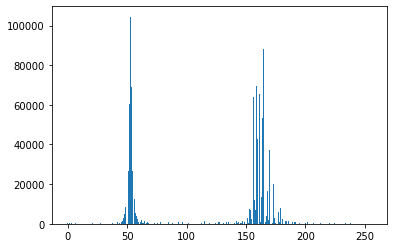

In [176]:
bins = 256
res = createColorHistogramArray(image, bins)
y_pos = np.arange(len(res))
size = np.zeros(bins)
# Create bars
plt.bar(y_pos, res)
plt.show()

### Self-Implemented Histogram for ROI:

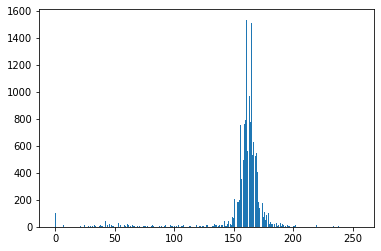

In [215]:
res2 = createColorHistogramArray(imageCar, bins)

# Create bars
y_pos2 = np.arange(len(res2))
plt.bar(y_pos2, res2)
plt.show()

* display the histogram for the Hue channel for the entire image and for the RIO (x,y) = (480, 260) to (640, 350). Vary the number of bins for testing purposes (**RESULT**).

### Playing with bins for ROI and shows us wanted Result for comparisson 

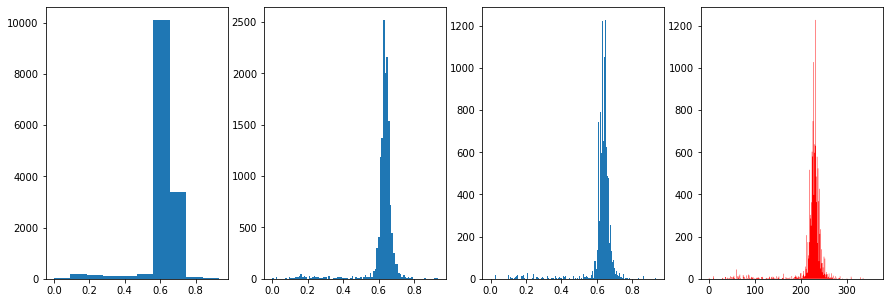

In [7]:
# Histograms for ROI image
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 4, 1)
histCar10 = createColorHistogram(imageCar, 10, ax1)
ax2 = plt.subplot(1, 4, 2)
histCar100 = createColorHistogram(imageCar, 100, ax2)
ax3 = plt.subplot(1, 4, 3)
histCar256 = createColorHistogram(imageCar, 256, ax3)
ax4 = plt.subplot(1, 4, 4)
histCar360 = createColorHistogram(imageCar, 360, True, ax4)

### Changing bins for entire image

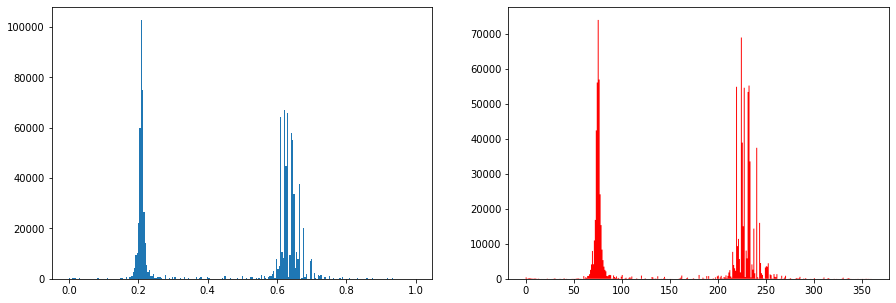

In [8]:
# Histograms for entire image
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
hist_whole_256 = createColorHistogram(image, 256, False, ax1)
ax2 = plt.subplot(1, 2, 2)
hist_whole_360 = createColorHistogram(image, 360, True, ax2)

## probability distribution
* implement the method outlined in the CAMSHIFT paper to create a probability distribution for a given object's hue histogram
* create the histogram of the car from the image "racecar.png" and apply the new function to the last frame of the video (images/racecar/151.jpg) (**RESULT**)


In [200]:
# Tip: in der Nacht sind alle Katzen grau ;)
histogramImage = res
number_pixels_image = sum(res)
histogramROI = res2
number_pixels_ROI = sum(res2)
def createProbDistribution(image, objectHist, nbins, minSaturation, minValue):
    H, W, C = image.shape
    new_img = np.zeros(H * W, np.uint8)
    #probability of bin = bin.val/number_pixels_ROI
    for i, (h,s,v) in enumerate (color.rgb2hsv(image).reshape(-1, C)):
        hue_bin = int(h*256)    
        hue_prob = (objectHist[hue_bin]/number_pixels_ROI)*100
        if v  > minValue and s > minSaturation: 
            hue_greyscale = (hue_prob*255)
            new_img[i] = hue_greyscale
        else: new_img[i] = 0
    return new_img.reshape(H, W)  

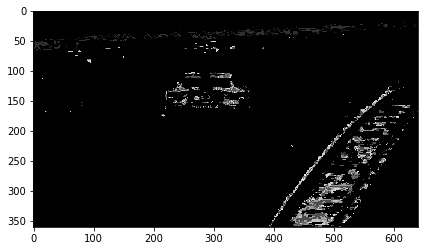

In [201]:
lastFrame = io.imread('images/racecar/151.jpeg')
probDistr = createProbDistribution(lastFrame, histogramROI, 256, MIN_SATURATION_CAR, MIN_VALUE_CAR)
io.imshow(probDistr, cmap ='gray')

## Exercise 3.2 - Mean Shift
* Implement the Mean Shift method for a ROI as described in the lecture. Test the algorithm on the image sequences "images/racecar/*.jpg" or "images/taco/*.jpg". Select the appropriate tracking window (to reduce the file size I have reduced the images by a factor of 2, i.e. the ROI from above must be adjusted accordingly). 
* Draw the trajectory of the objects as returned by Mean Shift. (**RESULT**)

### show ROI in image


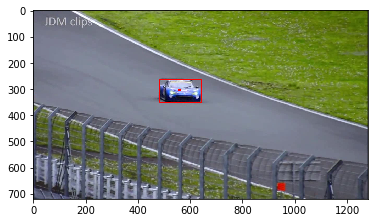

In [204]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="red"
        )
    )    
    out.imshow(image)

# 1. Choose a search window size.
# 2. Choose the initial location of the search window.
drawROI(image, 480, 260, 160, 90)

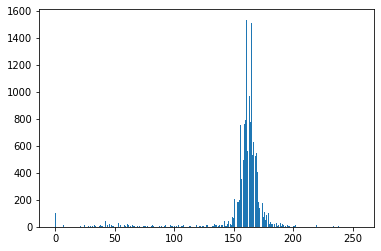

In [216]:
imageROI = image[260:350, 480:640]
histCar_ROI = createColorHistogramArray(imageROI, 256)
# Create bars
y_pos3 = np.arange(len(histCar_ROI))
plt.bar(y_pos3, histCar_ROI)
plt.show()

In [255]:
ROI_x = 480
ROI_y = 260
ROI_w = 160
ROI_h = 90

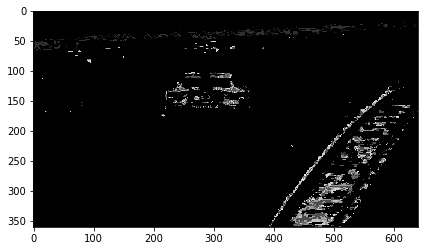

In [217]:
probDistrCar = createProbDistribution(lastFrame, histCar_ROI, 256, MIN_SATURATION_CAR, MIN_VALUE_CAR)
io.imshow(probDistrCar, cmap ='gray')

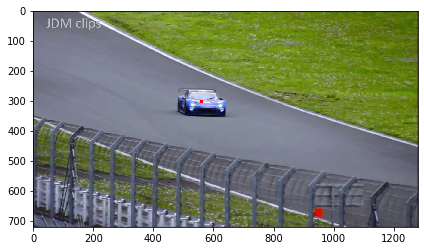

In [256]:
# 3. Compute the mean location in the search window.
mean_x=int(ROI_w/2)
mean_y=int(ROI_h/2)
mid_x = ROI_x + mean_x
mid_y = ROI_y + mean_y
plus_2_x = mid_x +5
plus_2_y = mid_y +5
min_2_x = mid_x - 5 
min_2_y = mid_y - 5

red = [0,0,255]
image[min_2_y:plus_2_y, min_2_x:plus_2_x]=[255,0,0]
io.imshow(image)

In [271]:
# 4. Center the search window at the mean location
x,y = np.where(probDistrCar == probDistrCar.max())
current_x = mid_x
current_y = mid_y

def find_most_nearest_most_likely (x, y, current_x, current_y):
    smallest_x = current_x
    smallest_y = current_y
    smallest = 100
    list_pt = []
    for i in x:
        for j in y:
            distance = np.sqrt( ((current_x - i)**2) + ((current_y - j)**2))
            if distance < smallest:
                smallest_x = i
                smallest_y = j
            continue
    list_pt.append(smallest_x)
    list_pt.append(smallest_y)
    return list_pt

p_x, p_y = find_most_nearest_most_likely (x, y, current_x, current_y)

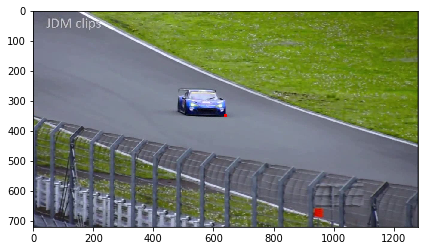

In [272]:
mean_x=int(ROI_w/2)
mean_y=int(ROI_h/2)
mid_p_x = p_x + mean_x
mid_p_y = p_y + mean_y
plus_2_p_x = mid_p_x +5
plus_2_p_y = mid_p_y +5
min_2_p_x = mid_p_x - 5 
min_2_p_y = mid_p_y - 5
red = [0,255,0]
image[min_2_p_y:plus_2_p_y, min_2_p_x:plus_2_p_x]=[255,0,0]
io.imshow(image)

In [268]:
#5. Repeat Steps 3 and 4 until convergence (or until the mean location moves less than a preset threshold).
def meanshift_process (imageROI, bins, image, histROI, minSaturation, minValue, ROI_x, ROI_y, ROI_w, ROI_h):
    histCar_ROI = createColorHistogramArray(imageROI, bins)
    probDistrCar = createProbDistribution(image, histROI, bins, minSaturation, minSaturation)
    mean_x=int(ROI_w/2)
    mean_y=int(ROI_h/2)
    current_x = ROI_x + mean_x
    current_y = ROI_y + mean_y
    red = [0,0,255]
    image[min_2_y:plus_2_y, min_2_x:plus_2_x]=[255,0,0]
    x,y = np.where(probDistrCar == probDistrCar.max())
    res = find_most_nearest_most_likely (x, y, current_x, current_y)
    return res

def pre_meanshift (res, imageROI, bins, image, histROI, minSaturation, minValue, ROI_x, ROI_y, ROI_w, ROI_h):
    if res == 0: 
        p_x = ROI_x
        p_y = ROI_y
    else: 
        p_x, p_y = res
        res = meanshift_process(imageROI, bins, i, histCar_ROI, MIN_SATURATION_CAR, MIN_VALUE_CAR, p_x, p_y, ROI_w, ROI_h)
    return res
    

In [269]:
res = 0
for i, image_path in enumerate(tqdm(glob.glob('./images/racecar/*.jpg'))):
    image = io.imread(image_path)   
    res = pre_meanshift(res, imageROI, bins, i, histCar_ROI, MIN_SATURATION_CAR, MIN_VALUE_CAR, ROI_x, ROI_y, ROI_w, ROI_h)
    print(res)
    io.imsave('./output2/' + str(i) +'.jpg', image)
    

0it [00:00, ?it/s]


##  Exercise 3.3 - CAMSHIFT
* extend your algorithm by adjusting the size of the ROI and finding the object's orientation
* execute the algorithm again on one of the image sequences and draw an ellipse on the image, which represents the found parameters (**RESULT**)

In [ ]:
1. First, set the calculation region of the probability
distribution to the whole image.
2. Choose the initial location of the 2D mean shift
search window.
3. Calculate the color probability distribution in the 2D
region centered at the search window location in an
area slightly larger than the mean shift window size.
4. Mean shift to convergence or for a set number of
iterations. Store the zeroth moment (area or size) and
mean location.
5. For the next video frame, center the search window at
the mean location stored in Step 4 and set the window